In [5]:
from sim_class import Simulation
import os
import numpy as np
import cv2
from PIL import Image
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from skimage.io import imread


In [2]:
sim = Simulation(num_agents=1, render=True)
image_path = sim.get_plate_image()
model_path = 'luka2_233582_unet_model_root_256px.h5'


Loading model...
Processing image and generating mask...
Detecting roots and showing results...
Root tips detected at robot coordinates: [array([2.56527091e+01, 6.54060054e+01, 5.70000000e-02]), array([5.81458971e+01, 5.88664959e+01, 5.70000000e-02]), array([7.95014830e+01, 5.22758965e+01, 5.70000000e-02]), array([1.04688813e+02, 5.23269864e+01, 5.70000000e-02]), array([1.32992627e+02, 5.49836621e+01, 5.70000000e-02])]


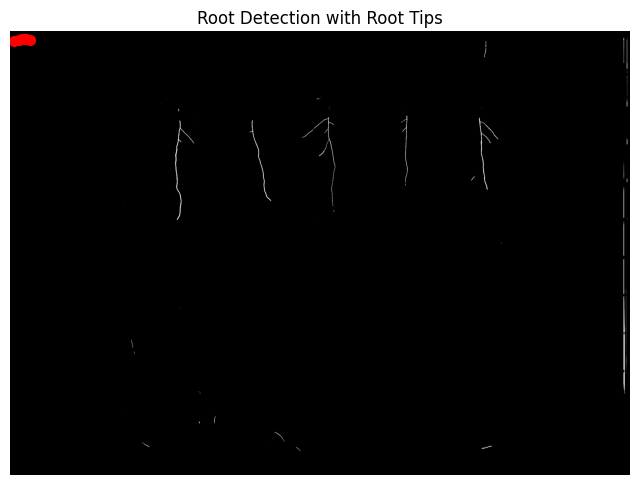

In [ ]:
# Function to convert root tip pixel coordinates to robot coordinates
def convert_to_robot_coordinates(root_tip_pixel, plate_size_mm, plate_size_pixels, plate_position_robot):
    # Conversion factor: how many millimeters per pixel
    conversion_factor = plate_size_mm / plate_size_pixels  # Conversion factor from pixel to mm
    
    # Convert the pixel coordinates to millimeters
    root_tip_mm = np.array(root_tip_pixel) * conversion_factor
    
    # Add the robot's plate position (x, y) while keeping the z constant
    # The z-coordinate of the robot's plate is already included in plate_position_robot[2]
    root_tip_robot = root_tip_mm + plate_position_robot[:2]  # Add x and y offsets

    # Return the full robot coordinates (x, y, z)
    root_tip_robot = np.append(root_tip_robot, plate_position_robot[2])  # Use z from robot position

    return root_tip_robot

# Plate size in mm and pixels
plate_size_mm = 150  # Plate size in mm
plate_size_pixels = 2936  # Plate size in pixels
plate_position_robot = np.array([0.10775, 0.062, 0.057])  # Robot's current position

# Load the model
def load_model_tf(model_path):
    model = load_model(model_path, compile=False)  # Set compile=False for inference
    return model

# Preprocessing function for test images
def preprocess_image(image, patch_size=(256, 256)):
    image = image.convert('L')  # Convert to grayscale
    image = image.resize(patch_size)  # Resize to the size the model expects
    image_array = np.array(image) / 255.0  # Normalize to [0, 1]
    image_array = np.expand_dims(image_array, axis=(0, -1))  # Add batch and channel dimensions
    return image_array

# Postprocessing function for predicted masks
def postprocess_mask(mask_array):
    mask = mask_array.squeeze()  # Remove batch and channel dimensions
    mask = (mask > 0.5).astype(np.uint8)  # Convert to binary mask (threshold = 0.5)
    return mask

# Function to process image in patches and reassemble the full mask
def process_image_in_patches(image_path, model, patch_size=(256, 256)):
    image = Image.open(image_path)
    patches = create_patches(image, patch_size)
    
    img_width, img_height = image.size
    mask = np.zeros((img_height, img_width), dtype=np.uint8)  # Initialize an empty mask

    patch_idx = 0
    for patch, left, top in patches:
        # Preprocess each patch and make a prediction
        image_array = preprocess_image(patch, patch_size)
        prediction = model.predict(image_array, verbose=0)
        mask_patch = postprocess_mask(prediction)

        # Calculate the valid mask area considering image boundaries
        mask_height, mask_width = mask_patch.shape
        valid_height = min(mask_height, img_height - top)
        valid_width = min(mask_width, img_width - left)

        # Ensure the mask patch fits within the boundaries of the full mask
        mask[top:top + valid_height, left:left + valid_width] = mask_patch[:valid_height, :valid_width]

        patch_idx += 1

    return mask

# Function to detect and segment individual roots within boxes, and extract root tips
def detect_roots_in_boxes(input_mask):
    # Use the predicted mask directly
    mask = input_mask

    # Ensure mask is binary (0 for background, 1 for root area)
    mask = mask > 0  # Assumes root areas are non-zero in the predicted masks

    # Crop the image to focus on the root areas (cut equally from both sides)
    original_height, original_width = mask.shape
    crop_width = 2935
    crop_height = 2935

    # Ensure the image is large enough for the desired crop
    if original_width > crop_width and original_height > crop_height:
        x_start = (original_width - crop_width) // 2
        x_end = x_start + crop_width
        y_start = (original_height - crop_height) // 2
        y_end = y_start + crop_height

        mask = mask[y_start:y_end, x_start:x_end]
    else:
        print(f"Image is too small to crop to {crop_width}x{crop_height}. Skipping.")
        return []

    # Define the number of boxes (here we use 5)
    num_boxes = 5
    box_width = mask.shape[1] // num_boxes  # Divide the width of the cropped image into 5 parts

    # List to hold the root tip coordinates
    root_tip_coords_for_image = []

    # Iterate through the boxes
    for i in range(num_boxes):
        # Define the current box (region of interest)
        x_start = i * box_width
        x_end = (i + 1) * box_width if i < num_boxes - 1 else mask.shape[1]
        box_mask = mask[:, x_start:x_end]

        # Remove the top and bottom 10% of the box for noise cleaning
        top_cutoff = int(box_mask.shape[0] * 0.10)
        bottom_cutoff = int(box_mask.shape[0] * 0.90)
        box_mask[top_cutoff:bottom_cutoff, :] = box_mask[top_cutoff:bottom_cutoff, :]

        # Use cv2.connectedComponentsWithStats to find connected components in the box
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(box_mask.astype(np.uint8), connectivity=8)

        # Filter components by size and keep only the largest root in the box
        max_length = 0
        primary_root = None
        root_tip_location = None  # To store the location of the root tip

        for label_idx in range(1, num_labels):  # Skip background (label 0)
            component_size = stats[label_idx, cv2.CC_STAT_AREA]
            if component_size > 50:  # Example size threshold for roots
                # Assume the largest component belongs to the root in the box
                component_coords = np.column_stack(np.where(labels == label_idx))
                start_point = component_coords[0]
                end_point = component_coords[-1]

                # Calculate the Euclidean distance (length of the root)
                length = np.linalg.norm(np.array(start_point) - np.array(end_point))

                # If it's the largest root, store the root tip location
                if length > max_length:
                    max_length = length
                    primary_root = label_idx
                    root_tip_location = tuple(end_point)

        # If a root tip is found, adjust coordinates back to the full image
        if root_tip_location is not None:
            # Adjust root tip coordinates by adding the cropping offset
            root_tip_location_full_image = (root_tip_location[1] + x_start, root_tip_location[0] + y_start)
            root_tip_coords_for_image.append(root_tip_location_full_image)

    # Convert root tip coordinates to robot coordinates
    root_tip_robot_coords = []
    for coord in root_tip_coords_for_image:
        root_tip_robot = convert_to_robot_coordinates(coord, plate_size_mm, plate_size_pixels, plate_position_robot)
        root_tip_robot_coords.append(root_tip_robot)

    return root_tip_robot_coords

# Main block to load model and show result
def main(image_path, model_path):
    print("Loading model...")
    model = load_model_tf(model_path)

    print("Processing image and generating mask...")
    mask = process_image_in_patches(image_path, model)

    print("Detecting roots and showing results...")
    root_tip_coordinates = detect_roots_in_boxes(mask)

    # Print the root tip coordinates in robot coordinates
    print(f"Root tips detected at robot coordinates: {root_tip_coordinates}")

    # Visualize the root tips on the mask
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(mask, cmap='gray')

    # Plot root tips as red dots
    for coord in root_tip_coordinates:
        ax.scatter(coord[0], coord[1], color='red', s=50, zorder=5)

    ax.set_title("Root Detection with Root Tips")
    ax.axis('off')  # Hide axes for cleaner display
    plt.show()

# Example usage
if __name__ == "__main__":
    main(image_path, model_path)


Coordinates:

Root 1: (25.6527091, 65.4060054, 0.057)

Root 2: (58.1458971, 58.8664959, 0.057)

Root 3: (79.501483, 52.2758965, 0.057)

Root 4: (104.688813, 52.3269864, 0.057)

Root 5: (132.992627, 54.9836621, 0.057)

In [2]:
from ot2_gym_wrapper import OT2GymWrapper
from PID_controller_2 import PIDController
import numpy as np

Testing PID gains: kp = 0.5, ki = 0.05, kd = 0.05
Target position reached with gains: 0.5, 0.05, 0.05
Final error with gains 0.5, 0.05, 0.05: 0.0089 meters

Testing PID gains: kp = 1.0, ki = 0.1, kd = 0.1
Target position reached with gains: 1.0, 0.1, 0.1
Final error with gains 1.0, 0.1, 0.1: 0.0096 meters

Testing PID gains: kp = 1.5, ki = 0.2, kd = 0.1
Target position reached with gains: 1.5, 0.2, 0.1
Final error with gains 1.5, 0.2, 0.1: 0.0083 meters

Testing PID gains: kp = 2.0, ki = 0.1, kd = 0.2
Final error with gains 2.0, 0.1, 0.2: 393051046431458.6875 meters

Testing PID gains: kp = 0.8, ki = 0.05, kd = 0.15
Target position reached with gains: 0.8, 0.05, 0.15
Final error with gains 0.8, 0.05, 0.15: 0.0000 meters

Testing PID gains: kp = 0.9, ki = 0.1, kd = 0.3
Target position reached with gains: 0.9, 0.1, 0.3
Final error with gains 0.9, 0.1, 0.3: 0.0093 meters

Testing PID gains: kp = 1.2, ki = 0.15, kd = 0.05
Target position reached with gains: 1.2, 0.15, 0.05
Final error with

In [3]:
# Initialize the OT2 environment
env = OT2GymWrapper(render=True)
obs = env.reset()

# Root positions (these will be the goal positions for the robot)
root_positions = np.array([
    [25.6527091, 65.4060054, 0.057],
    [58.1458971, 58.8664959, 0.057],
    [79.501483, 52.2758965, 0.057],
    [104.688813, 52.3269864, 0.057],
    [132.992627, 54.9836621, 0.057]
])

# PID gains (you can tune these values)
pid_gains = (1.0, 0.1, 0.1)  # Example values for kp, ki, kd

# Set the tolerance threshold for reaching the goal
goal_reach_threshold = 0.01  # 1mm tolerance for goal proximity


In [5]:
# Iterate over each root position (goal position for each inoculation)
for plant_index, goal_position in enumerate(root_positions):
    print(f"Moving to root {plant_index + 1} at position {goal_position}")
    
    # Initialize the PID controller for the current root position
    controller = PIDController(*pid_gains, target_position=goal_position)
    
    while True:
        # Get the current position of the robot from the environment
        current_position = env._get_pipette_position()  # Ensure this method returns the correct position

        # Update the PID controller and calculate movement
        movement = controller.update_position(current_position)

        # Apply the movement to the environment (send velocity action to the robot)
        action = movement  # Assuming this is how movement is interpreted in your environment
        obs, reward, done, info = env.step(action)  # Expect only 4 values here

        # Calculate the error (distance) between the current robot position and the goal
        distance = np.array(goal_position) - current_position  # Goal - Current position
        error = np.linalg.norm(distance)  # Euclidean distance

        # Check if the robot is close enough to the goal position
        if error < goal_reach_threshold:
            print(f"Goal reached for root {plant_index + 1}!")
            # Drop the inoculum (action = [0, 0, 0, 1] to indicate inoculation)
            action = np.array([0, 0, 0, 1])  # Inoculation action (assuming it’s defined in OT2GymWrapper)
            obs, reward, done, info = env.step(action)
            break  # Exit the loop for this root, move to the next one
        
        if done:
            print(f"Episode terminated, resetting...")
            obs, info = env.reset()
            break  # Reset to start the process again


Moving to root 1 at position [2.56527091e+01 6.54060054e+01 5.70000000e-02]


error: Not connected to physics server.